In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import csv
from itertools import islice
from PIL import Image

In [5]:
def qupath_cells_detection_to_dataframe(file_path):
    """
    Ream input file that contains QuPah cells detection and return and pandas data frame
    :param file_path: (str). Path to the file that contains cells coordinates
    :param lateral: (float) lateral position
    :return: Pandas dataframe containing data from input file_path
    """
    workbook = openpyxl.Workbook()
    worksheets = workbook.worksheets[0]

    with open(file_path, 'r', encoding="utf-8") as data:
        reader = csv.reader(data, delimiter='\t')
        for row in reader:
            worksheets.append(row)
    data = worksheets.values
    cols = next(data)[1:]
    data = list(data)
    idx = [r[0] for r in data]
    data = (islice(r, 1, None) for r in data)
    dataframe = pd.DataFrame(data, index=idx, columns=cols)
    return dataframe

In [8]:
def read_cells_coordinate(dataframe):
    """
    Read file that contains cell positions and create cells centroids x,y position
    :param dataframe:(Pandas dataframe) containing cells coordinate and metadata (layer, ...)
    :return:
        tuple:
            - cells_centroid_x np.array of shape (number of cells, ) of type float
            - cells_centroid_y np.array of shape (number of cells, ) of type float
    """

    try:
        cells_centroid_x = dataframe['Centroid X µm'].to_numpy(dtype=float)
        cells_centroid_y = dataframe['Centroid Y µm'].to_numpy(dtype=float)
        return cells_centroid_x, cells_centroid_y
    except KeyError:
        raise NotValidImage

In [20]:
dataframe = qupath_cells_detection_to_dataframe('../../../../Aligning_Big_Brains_Atlases/V1_Adult_Mouse_full_Brain_image_um.ome.tiff.txt')

In [9]:
cells_centroid_x, cells_centroid_y = read_cells_coordinate(dataframe)

In [24]:
image_path = '/Users/jacquemi/working_dir/Aligning_Big_Brains_Atlases/Dataset/spatial/V1_Adult_Mouse_Brain_image/spatial/full_brain_V1_Adult_Mouse_Brain_image.png'
full_brain_V1_Adult_Mouse_Brain_png_image = np.array(Image.open(image_path).convert('RGB'))

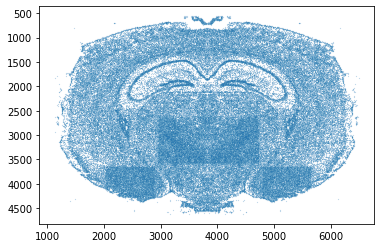

In [17]:
plt.scatter(cells_centroid_x, cells_centroid_y, s = .01)
plt.gca().invert_yaxis()

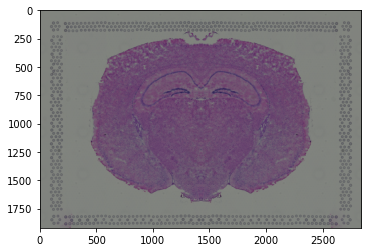

In [25]:
plt.imshow(full_brain_V1_Adult_Mouse_Brain_png_image)

In [26]:
pwd

'/Users/jacquemi/working_dir/Rat_Nissl/rat_sscx_nissl_analysis/Notebooks/notebooks'